In [1]:
import os, sys
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
#sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import rcParams


In [2]:
path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
table_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/tables/new/'
figure_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/figures/new/'


In [3]:
adata = sc.read_h5ad(path+'data/ALO_viscRNAseq.h5ad')
adata

AnnData object with n_obs × n_vars = 21044 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [4]:
filtered =adata[(adata.obs.high_quality=='True') #& 
#                (adata.obs.ID.isin(['24h_infected_DMSO', '24h_infected_RMC-113', '24h_uninfected_DMSO', '24h_uninfected_RMC-113'])) &
#               (adata.obs.cell_type.isin(['AT2-like cells']))
               ]
filtered

View of AnnData object with n_obs × n_vars = 20672 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [5]:
### Normalize RNA counts
filtered.layers['counts'] = filtered.X.copy()

sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered)
filtered.raw = filtered.copy()

In [10]:
ress = {}
for s in filtered.obs['ID'].cat.categories:
    print(s)
    for ct in filtered.obs.cell_type.cat.categories:
        if ct == 'NGFR-HOPX-CEACAM6+': continue
        adata_ct = filtered[filtered.obs.cell_type == ct].copy()
#        sc.pp.filter_genes(adata_ct, min_cells=3)
        sc.tl.rank_genes_groups(adata_ct, 'ID', method='wilcoxon', reference = s, key_added = "wilcoxon")
        ress[(ct, s)] = adata_ct.uns['wilcoxon']
        
        
markers = pd.DataFrame([])
for k,results in ress.items():
    ct = k[0]
    s = k[1]
    out = np.array([[0,0,0,0,0,0,0,0]])
    for group in results['names'].dtype.names:
        out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['pvals'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group]),).astype('object'),
                                     np.array([s] * len(results['names'][group]),).astype('object'),
                                     np.array([ct] * len(results['names'][group]),).astype('object'),
                                    )).T
                        ))
    out = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'pval', 'lfc', 'Condition', 'reference', 'cell_type'])
    markers = pd.concat([markers, out], axis=0, join='outer')


markers['label'] = markers['Condition']+'_'+markers['reference']
labelmap = {'24h_infected_RMC-113_24h_infected_DMSO': '24h infected, RMC-113 vs DMSO',
           '24h_uninfected_RMC-113_24h_uninfected_DMSO': '24h uninfected, RMC-113 vs DMSO',
           '24h_infected_RMC-113_24h_uninfected_RMC-113': '24h RMC-113, infected vs uninfected',
           '24h_infected_DMSO_24h_uninfected_DMSO': '24h DMSO, infected vs uninfected',
           }
markers['label'] = markers['label'].map(labelmap)
markers = markers[~markers['label'].isna()]
markers

24h_infected_DMSO
24h_infected_RMC-113
24h_uninfected_DMSO
24h_uninfected_RMC-113
4h_infected_DMSO
4h_infected_RMC-113
4h_uninfected_DMSO
4h_uninfected_RMC-113


,Gene,scores,pval_adj,pval,lfc,Condition,reference,cell_type,label,log2fc
1.0,GCLC,23.513735,1.850707e-117,2.951545e-122,3.272767,24h_infected_RMC-113,24h_infected_DMSO,AT1-like cells,"24h infected, RMC-113 vs DMSO",2.736525
2.0,TKT,22.908482,1.199009e-111,3.824408e-116,2.222574,24h_infected_RMC-113,24h_infected_DMSO,AT1-like cells,"24h infected, RMC-113 vs DMSO",1.863293
3.0,NQO1,20.681501,1.062469e-90,5.083340e-95,5.019171,24h_infected_RMC-113,24h_infected_DMSO,AT1-like cells,"24h infected, RMC-113 vs DMSO",3.046303
4.0,FTL,20.265526,4.062874e-87,2.591821e-91,4.330327,24h_infected_RMC-113,24h_infected_DMSO,AT1-like cells,"24h infected, RMC-113 vs DMSO",3.462729
5.0,ALDH3A1,17.159653,6.675524e-62,5.323130e-66,4.429985,24h_infected_RMC-113,24h_infected_DMSO,AT1-like cells,"24h infected, RMC-113 vs DMSO",3.165310
...,...,...,...,...,...,...,...,...,...,...
1504868.0,DNAJA1,-11.646770,1.067387e-27,2.383206e-31,-3.421590,4h_infected_RMC-113,4h_uninfected_RMC-113,Basal-like cells,"4h RMC-113, infected vs uninfected",-3.131220
1504869.0,EIF3A,-11.834810,1.347732e-28,2.579268e-32,-1.320401,4h_infected_RMC-113,4h_uninfected_RMC-113,Basal-like cells,"4h RMC-113, infected vs uninfected",-1.219675
1504870.0,DDX21,-12.088918,8.420905e-30,1.208684e-33,-3.378631,4h_infected_RMC-113,4h_uninfected_RMC-113,Basal-like cells,"4h RMC-113, infected vs uninfected",-3.258477
1504871.0,HSPA8,-12.133640,5.491515e-30,7.006383e-34,-2.998584,4h_infected_RMC-113,4h_uninfected_RMC-113,Basal-like cells,"4h RMC-113, infected vs uninfected",-2.748133


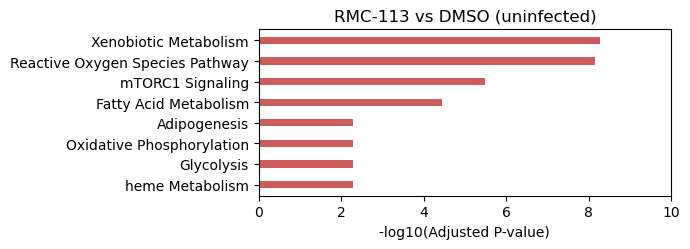

In [11]:
#### Figure 4j

import gseapy as gp
from gseapy import barplot, dotplot

ct = 'AT2-like cells'
label = '24h uninfected, RMC-113 vs DMSO'
label2plot = '24h_uninfected_RMC113_vs_DMSO'
title='RMC-113 vs DMSO (uninfected)'

go_genes = markers[(markers.cell_type.isin([ct])) & 
                   (markers.label.isin([label])) & 
                  (abs(markers.lfc)>=1.0) & (markers.pval_adj < 0.05)]
go_genes = list(go_genes.Gene.unique())


enrich_all = gp.enrichr(gene_list=go_genes,
                     gene_sets=['MSigDB_Hallmark_2020'],
                     cutoff = 0.5).results


enrich_all = enrich_all[enrich_all['Adjusted P-value']<0.05]
enrich_all['Adjusted P-value'] = np.log10(enrich_all['Adjusted P-value']) * -1

df = enrich_all
df = df.reset_index().set_index('Term')['Adjusted P-value']
df = df.iloc[::-1]

width = 0.35 
h=df.shape[0]
fig = plt.subplots(figsize =(7, h*0.2+1))
p1 = plt.barh(df.index, df, width,color='indianred')
 
plt.xlabel('-log10(Adjusted P-value)')
plt.title(f'{title}')
plt.xticks(np.linspace(0,10, 6), [0, 2, 4, 6, 8, 10,]) 
plt.tight_layout()
#plt.savefig(f'{figure_path}Barplot_enriched_pathways_{ct}_{label2plot}_all_Hallmarks_long.svg',)
plt.show()



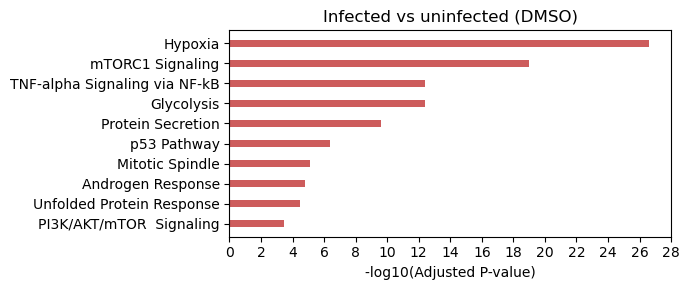

In [12]:
#### Figure 4k

ct = 'AT2-like cells'
label = '24h DMSO, infected vs uninfected'
label2plot = '24h_DMSO_infected_uninfected'
title='Infected vs uninfected (DMSO)'

go_genes = markers[(markers.cell_type.isin([ct])) & 
                   (markers.label.isin([label])) & 
                  (abs(markers.lfc)>=1.0) & (markers.pval_adj < 0.05)]
go_genes = list(go_genes.Gene.unique())


enrich_all = gp.enrichr(gene_list=go_genes,
                     gene_sets=['MSigDB_Hallmark_2020'],
                     cutoff = 0.5).results


enrich_all = enrich_all[enrich_all['Adjusted P-value']<0.05]
enrich_all['Adjusted P-value'] = np.log10(enrich_all['Adjusted P-value']) * -1

df = enrich_all
df = df.reset_index().set_index('Term')['Adjusted P-value']
df = df[:10].iloc[::-1]

#ind = np.arange(N)   
width = 0.35 
h=df.shape[0]
fig = plt.subplots(figsize =(7, h*0.2+1))
p1 = plt.barh(df.index, df, width,color='indianred')
 
plt.xlabel('-log10(Adjusted P-value)')
plt.title(f'{title}')
#plt.legend((p1[0]), ('Upregulated', 'Downregulated'))
plt.xticks(np.linspace(0,28, 15), [0, 2, 4, 6, 8, 10,12,14,16,18,20,22,24,26,28]) 
plt.tight_layout()
#plt.savefig(f'{figure_path}Barplot_enriched_pathways_{ct}_{label2plot}_all_Hallmarks_long.svg',)
plt.show()


In [14]:
marker_genes = ["MTOR", ## "mTORC1", 
                "ULK1", "ATG13",
                "RB1CC1", ## "FIP200",
                "BECN1", 
                #"ATG14", 
#                   "PIK3C3", ## "PIK3C3/VPS34", 
                'ATG7', 'ATG8', 'ATG10', 'ATG12', 'ATG16L1', 
                'MAP1LC3B', 'SQSTM1', 
                'WDFY3','NBR1', 'TAX1BP1',
                "LAMP2", "TECPR1",
                "ATG14", "STX17", "VAMP8",
                "SNAP29", "RAB7A",  
                "PLEKHM1", "GABARAP",
                "VPS11", "VPS16", "VPS18",
                "VPS33A", "VPS33B", ## "Vps33", 
                   "VPS39", "VPS41",
                ]
genes = [x.upper() for x in marker_genes if x.upper() in filtered.var_names]
markers_genes = markers.reset_index().set_index('Gene').loc[genes, :].reset_index().set_index('index').fillna(0)
markers_tmp = markers_genes[markers_genes['cell_type'].isin([ct])]


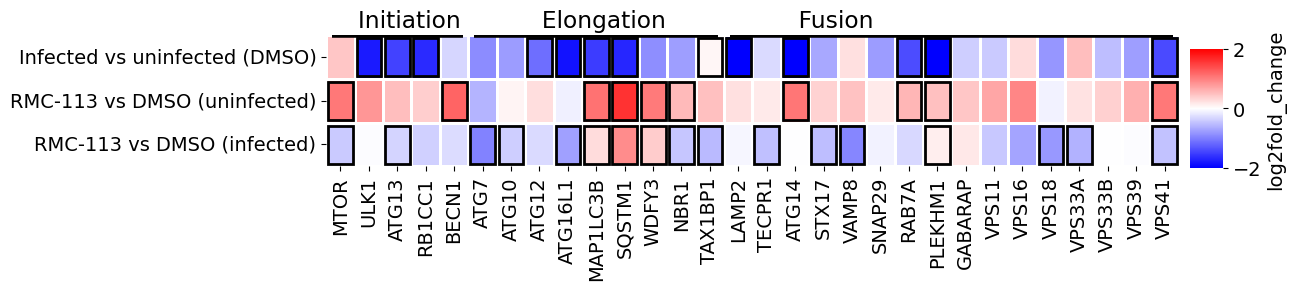

In [23]:
#### Figure 4l

import matplotlib
from matplotlib import rcParams
rcParams['font.size']=14

fig, ax1 = plt.subplots(1,1,
                               sharex=True,
                               figsize=(11,1.7), 
                               gridspec_kw={'wspace':0.4}
                              )
cbar_ax = fig.add_axes([.91, .1, .03, .7])


#### 24h plots
ind = [0,3,2,]
tmp = markers_tmp.pivot_table(index='Gene', columns='label', values='lfc')
tmp = tmp[tmp.columns[ind]].loc[genes]
sns.heatmap(tmp.T, cmap='bwr', vmin=-2, vmax=2, ax=ax1, 
            linewidths=1,
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2fold_change'})
pval = markers_tmp.pivot_table(index='Gene', columns='label', values='pval')
pval = pval[pval.columns[ind]].loc[genes]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            ax1.add_patch(
                matplotlib.patches.Rectangle(
                    #(j, i),
                    #1.0, 1.0,
                    (j+0.07, i+0.07),
                    0.87, 0.87,
                    edgecolor='black',
                    fill=False,
                    lw=2
                ) )
ax1.set_yticklabels(['Infected vs uninfected (DMSO)', 'RMC-113 vs DMSO (uninfected)', 'RMC-113 vs DMSO (infected)',],
                   fontsize=14)
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.hlines(y=0., xmin=0.2, xmax=4.8, linewidth=4, color='k')
ax1.hlines(y=0., xmin=5.2, xmax=13.8, linewidth=4, color='k')
ax1.hlines(y=0., xmin=14.2, xmax=29.8, linewidth=4, color='k')

title = 'Initiation           Elongation                  Fusion                                     '
ax1.set_title(title)


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_24h_linewidth1_3_new_updated.svg', format="svg")
plt.show()


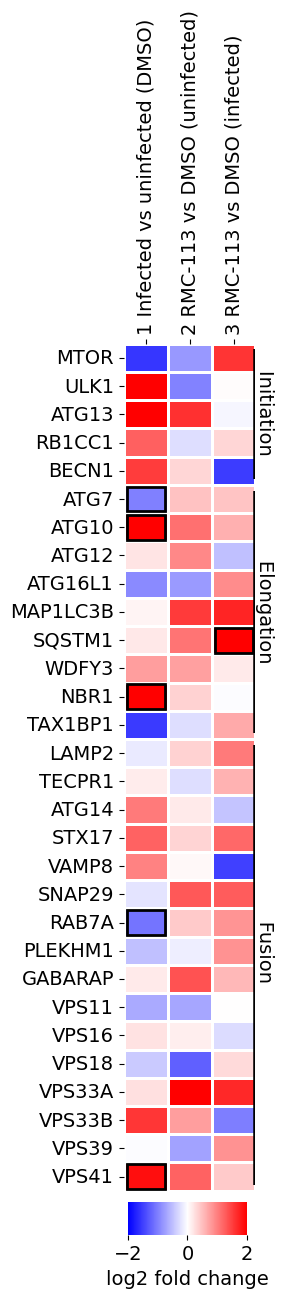

In [76]:
#### Figure S8b

fig, ax1 = plt.subplots(1,1,figsize=(1.7,11), gridspec_kw={'wspace':0.4})
cbar_ax = fig.add_axes([.15, .07, .7, .03])


#### 4h plots
ind = [4,7,6,]
tmp = markers_tmp.pivot_table(index='Gene', columns='label', values='lfc')
tmp = tmp[tmp.columns[ind]].loc[genes]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=ax1, 
            linewidths=1,
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change', 'orientation': 'horizontal'})
pval = markers_tmp.pivot_table(index='Gene', columns='label', values='pval')
pval = pval[pval.columns[ind]].loc[genes]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            ax1.add_patch(
                matplotlib.patches.Rectangle(
                     (i+0.07, j+0.07),
                    0.87, 0.87,
                    edgecolor='black',
                    fill=False,
                    lw=2
                ) )
ax1.set_xticklabels(['1 Infected vs uninfected (DMSO)', '2 RMC-113 vs DMSO (uninfected)', '3 RMC-113 vs DMSO (infected)',],
                   fontsize=14, rotation=90)
ax1.xaxis.tick_top()


ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.vlines(x=3.01, ymin=0.2, ymax=4.8, linewidth=4, color='k')
ax1.vlines(x=3.01, ymin=5.2, ymax=13.8, linewidth=4, color='k')
ax1.vlines(x=3.01, ymin=14.2, ymax=29.8, linewidth=4, color='k')

title = 'Initiation                 Elongation                                          Fusion'
#ax1.set_title(title)
ax1.text(1, 0.97, title, rotation=270, horizontalalignment='left',
     verticalalignment='top', transform=ax1.transAxes)


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()
